# Pricing Credit Portfolio

In this exercise we will price a basket default swap on five reference names. I will be using the following Sovereign names as basket assets:

- Austria
- Belgium
- France
- Germany
- Italy

Consider different inputs and how they affect the results - Risk and Sensitivity Analysis.

Where possible I have tried to implement some performance comparisons of the different computational methods, using Anaconda from continuum.io it is possible to test both vectorized CPU and GPU methods.

## Introduction

A Basket Default Swap (BDS) is an OTC exotic and can be considered along with a Credit Default Swap as a product that offers some protection (it is unlikely that return would equal the original investment in the occurence of a default) against a credit event, but the difference is that a BDS insures against a credit event on the $k^{th}$ default on a basket of n reference names. It should be noted that the payment is made for that entity only and not the rest of the names in the basket. In this particular example we will be using 5:

- Austria
- Belgium
- France
- Germany
- Italy

The premium (par spread) is paid as a fee over the life of contract or in the event of the $k^{th}$ default a return for the loss. Once the model / algorithm is established it will be possible to vary the input components to see how they affect the results, this can be found under the Risk and Sensitivity Analysis section.
        

## Outline

To model credit defaults, it is common practice to use same techniques used to priced using intensity models . A default is an event in time that impacts all cashflows that happen after that event. They are not based on Merton's model of capital structure of the firm value, nor the Altman Z rating of the firm but based on the idea that default is a random process. To simulate the arrival of a credit event we need to model an unknown random point in time $\large \tau \in \mathbb{R}_+ $


The default indicator function and the survival indicator (1-I(t)) are used to accomplish this

$I(t)={1_{\tau > T}}=\begin{cases} 1\  if \tau \lt T \\ 0\  if \tau \geqslant T \end{cases}$


### Poisson Process

The default time can be seen as the first jump of the Poison process, with the parameter $\lambda$ named as the intensity of the process and hence an intensity model. The Poison process is suitable since it has no memory of any other event, the inter arrival times are exponentially distributed, ($\tau_{n+1} - \tau_n$) and two or more jumps at exactly the same time are improbable. 

$P(t,T)\ =\ exp(-\lambda(T-t))$

With the probability starting at 1 (the start) and then diminishing over time to 0, at maturity. This can be considered an homogenous Poisson process. However in this case since the term structure of the hazard rates is not flat, $\lambda(t)$ is a non-negative function of time and thus an inhomogenous Poisson process.

$P(t,T)\ =\ exp\big( -\int_{t}^{T} \lambda(s)ds \big)$


In [2]:
# we need to setup some initial configuration for the rest of the notebook

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from scipy.interpolate import UnivariateSpline
from numpy import linspace, array, arange, exp

# for colour cycling in graphs
from itertools import cycle
cycol = cycle('bgrcmyk').next

# set defaults for charts
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
matplotlib.rcParams['font.size'] = 14.0

# interpolate for smooth curve
def plotInterpolatedCurveWithOrig(xdata=array, ydata=array, label=str):
    lincol = cycol()
    plt.plot(xdata, ydata, 'ro',c=lincol, ms=5, label=label)
    spl = UnivariateSpline(xdata, ydata)
    xs = linspace(min(xdata), len(xdata), 1000)
    spl.set_smoothing_factor(0.5)
    plt.plot(xs, spl(xs),':k', c=lincol, lw=2)

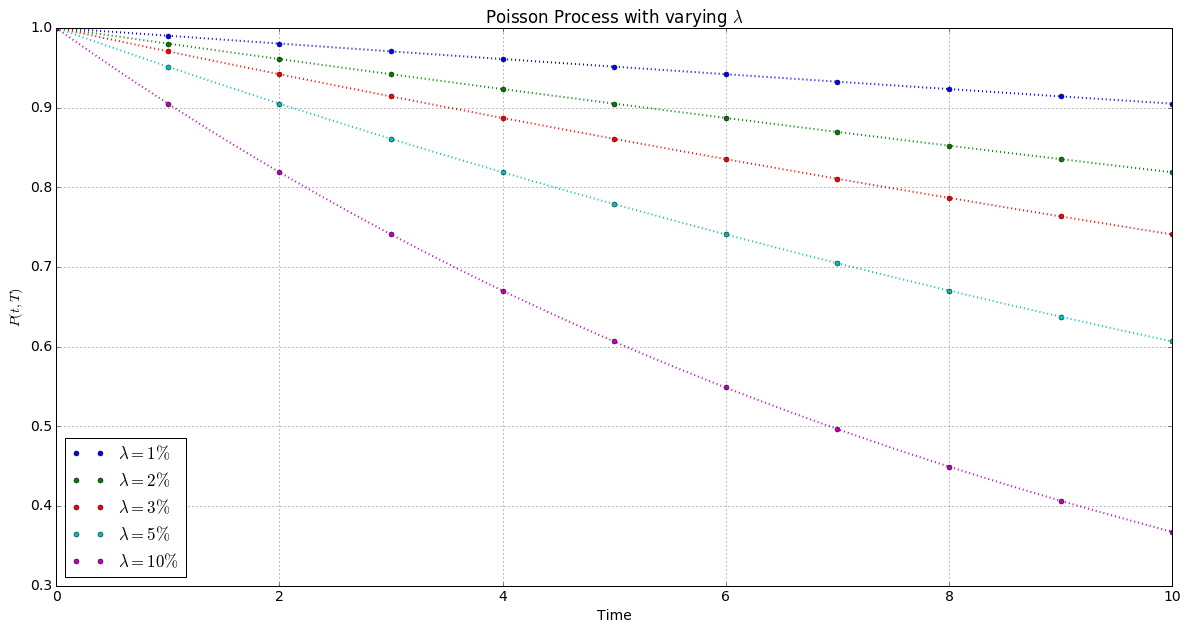

In [3]:
lRange = range(0,11)
l1 = [exp(-0.01*l) for l in lRange]
l2 = [exp(-0.02*l) for l in lRange]
l3 = [exp(-0.03*l) for l in lRange]
l5 = [exp(-0.05*l) for l in lRange]
l10 = [exp(-0.1*l) for l in lRange]

plt.grid()
plt.title('Poisson Process with varying $\lambda$')
plt.xlabel('Time')
plt.ylabel('$P(t,T)$')
plt.xlim(0,10)
plotInterpolatedCurveWithOrig(lRange,l1, '$\lambda = 1\% $')
plotInterpolatedCurveWithOrig(lRange,l2, '$\lambda = 2\% $')
plotInterpolatedCurveWithOrig(lRange,l3, '$\lambda = 3\% $')
plotInterpolatedCurveWithOrig(lRange,l5, '$\lambda = 5\% $')
plotInterpolatedCurveWithOrig(lRange,l10, '$\lambda = 10\% $')
plt.legend(loc='lower left')
# plt.legend(handles=[legs])


plt.show()

### Yield curves

To get a starting point for the credit spread, we will estimate it from the prices quoted in the market for different tenors. The spread being the difference between the asset and the US treasury bond rate for the same tenor. 

Using the following information from http://www.investing.com/rates-bonds/world-government-bonds, the plots for the bonds yields can be shown as:


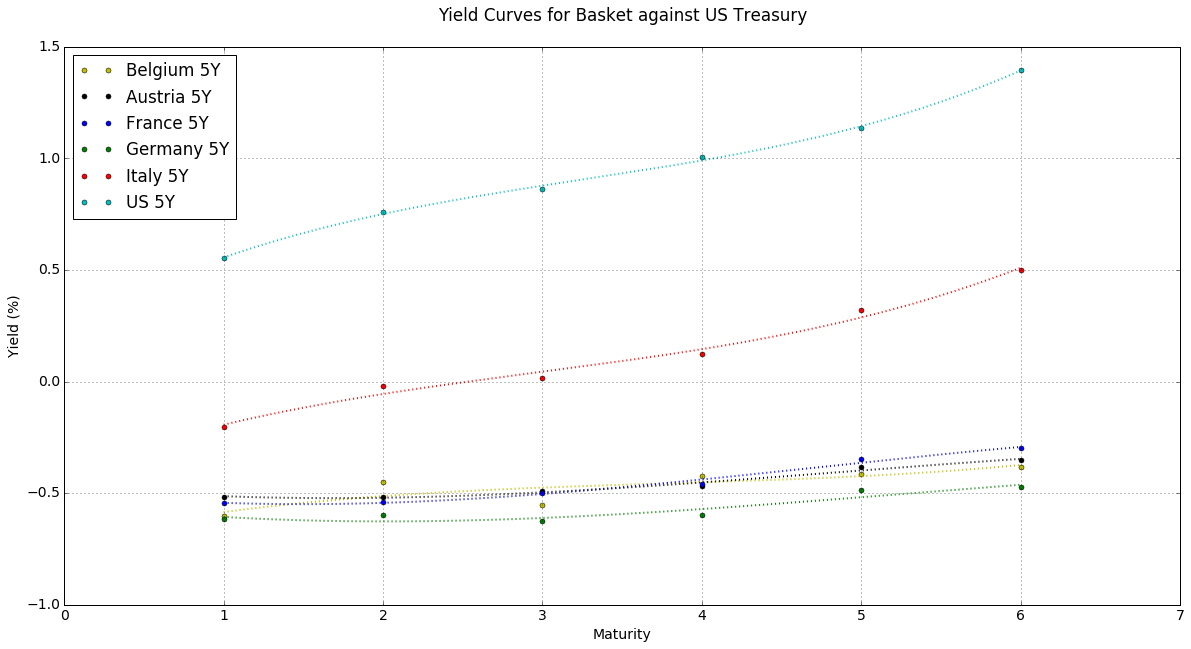

In [4]:
# set defaults for charts
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
matplotlib.rcParams['font.size'] = 14.0

# plot yield curves
usYc = [0.555,0.758,0.862,1.008302632,1.135,1.396]
autYc = [-0.515, -0.518,-0.49,-0.469,-0.384,-0.35]
beYc = [-0.602,-0.45,-0.551,-0.425,-0.412,-0.381]
frYc = [-0.545,-0.54,-0.497,-0.458,-0.347,-0.297]
deYc = [-0.616,-0.599,-0.625,-0.598,-0.484,-0.473]
itaYc = [-0.205,-0.019,0.018,0.125,0.321,0.499]
x = arange(1,7)

plt.grid()
plt.title('Yield Curves for Basket against US Treasury\n')
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
plt.xlim(0,7)
plotInterpolatedCurveWithOrig(x,beYc, 'Belgium 5Y')
plotInterpolatedCurveWithOrig(x,autYc, 'Austria 5Y')
plotInterpolatedCurveWithOrig(x,frYc, 'France 5Y')
plotInterpolatedCurveWithOrig(x,deYc, 'Germany 5Y')
plotInterpolatedCurveWithOrig(x,itaYc, 'Italy 5Y')
plotInterpolatedCurveWithOrig(x,usYc, 'US 5Y')
plt.legend(loc='upper left')
# plt.legend(handles=[legs])


plt.show()

The fact that most of the basket apart from Italy are negative yields should produce some interesting results. The plot does show a similarity to the US Treasury Curve, just flatter, with the exception of Germany

### Pricing the CDS

In order to price the Credit default swap we will need to take each step in the term and work out the premium leg and subsequently the default leg.

$PV(premium) = \sum_{n=1}^{N} \pi\ x\ N\ x\ \Delta t\ x \ DF_i \ x \ P(T_i) $

Where N is the notional, DF is the discount factor, PD is the probability of survival, R is the recovery rate.

For the default leg, it will be the sum of the of the default values up to the time of default, where the LGD (Loss Given Default) is N(1-R):

$PV(default) = \sum_{n=1}^{N} (1-R)\ x\ DF_i\ x\ PD(T_i,T_{i-1}) $

Once we have these, the fair price or the premium of the CDS can be deduced from:

$\large \pi = \frac{\sum_{n=1}^{N} (1-R)\ x\ DF_i\ x\ PD[T_i,T_{i-1}]}{\sum_{N}^{n=1}\ \Delta t\ x\ DF_i\ x\ P(T_i)}$


This is done programatically using the included CDS class.  https://github.com/morphean/module6/blob/master/cva/notebook/app/CreditDefaultSwap.py

#### Discount Factors
In order to calculate the discount factors for each time step we will use the following:

$D(0,T_n)=exp \large ( - \sum_{k=1}^{n}\ r_k\ \Delta t \large )$

#### Survival Probability
Assuming that at $T_0,P(T_0)=P(0)=1$. The survival function can be denoted:

$P(T_n)=exp \large ( - \sum_{k=1}^{n}\ \lambda_k\ \Delta t \large )$


Since the value of lambda will differ over the term, we need to bootstrap the survival probability. With the assumption that $PV(premium) = PV(default)$. We have the premium already so we need to reverse engineer (aka bootstrap).

$S_n = \frac{\Large (1-R) \sum_{n=1}^{N} D(0,T_n) (P(T_{n-1})-P(T_n))}{\Large \sum_{n=1}^{N} D(0,T_n) P(T_n)(\Delta t_n)} $

We will need to do this for $T_1$ and then proceed to do the same for each $T_n$ up to maturity to get the implied survival probabilties:

$PL_1 = DL_1$

...

$S_1D(0,T_1)P(T_1)\Delta t = (1-R)D(0,T_1)P(T_0)-P(T_1))$

...

$D(0,T_1)P(T_1)(S_1+\Delta t+ L) = LD(0,T_1)P(T_0)$

...

$P(T_1) = \Large \frac{L}{L+\Delta t_1S_1}$

where R is the recovery rate and L the LGD, $L = 1 - R$. This can then be expanded to the generalised function for (n=N):

$P(T_n) = \Large \frac{\sum_{n=1}^{N-1}(1-R)P(T_{n-1}) - ((1-R) + \Delta t_n S_n) P(T_n))}{D(0,T_n)((1-R)+\Delta t_n S_n} + \Large \frac {P(T_{N-1} L}{L + \Delta t_N S_N}$



### Term Structure of Hazard Rates

We can calculate the hazard rate $\lambda_n$ from the $P(T_n)$ and $P(T_n-1)$ taking the assumption that the hazard rates follow an inhomogenous Poisson process since we don't have the actual distribution and the function is piecewise constant.

$\large P(0,T_n) = exp(- \int_{0}^{T_n} \lambda s\ ds ) $

$\large \quad \quad \quad= exp( - \sum_{i=1}^{n} \lambda_i\Delta t_i)$

$\large \quad \quad \quad= exp( - \sum_{i=1}^{n-1} \lambda_i\Delta t_i -  \lambda_n\Delta t_n)$

$\large \quad \quad \quad= exp( - \sum_{i=1}^{n-1} \lambda_i\Delta t_i) - exp( \lambda_n\Delta t_n)$

$\large \quad \quad \quad= P(0,T_{n-1}) - exp( \lambda_n\Delta t_n)$

which can then expressed of the hazard rate as a log difference between the two survival probabilities.

$\large \lambda_n = -\frac{1}{\Delta t}\ log (\frac{P(0,T_n}{P(0,T_{n-1}})$

Using this formula with the bootstrapped data, the following data is obtained (link to s/s):

|  Name |Year| Spread | PD  | $\large \lambda_n$   |
|---|---|---|---|---|
|AUT|1| 115.70 |0.982479122318651|0.00767666961222201|
||2| 120.80 |0.958704317759161|0.01063864706076580|
||3| 141.30 |0.935158751440165|0.01079934088002760|
||4| 142.35 |0.907384926248782|0.01309378208757440|
||5| 154.70 |0.881781194909988|0.01243072764491560|
|BEL|1| 115.70 |0.981081478816816|0.00829492296551629|
||2| 120.80 |0.960898216825752|0.00902768958653353|
||3| 141.30 |0.932269105082887|0.01313609528367980|
||4| 142.35 |0.910168391619283|0.01041954293598230|
||5| 154.70 |0.879621843358195|0.01482574371445270|
|FRA |1| 110.00 |0.981996726677578|0.00788995985891059|
||2| 129.80 |0.958018344322737|0.01073621502719710|
||3| 135.90 |0.934859797608484|0.01062734118316680|
||4| 145.65 |0.908106923903281|0.01260949694348420|
||5| 148.20 |0.884632754882147|0.01137397123783840|
|GER|1| 117.10 |0.980856942015007|0.00839432985148177|
||2| 135.70 |0.956178825998711|0.01106654787067210|
||3| 148.70 |0.928935070875451|0.01255376280085040|
||4| 159.65 |0.899723183928248|0.01387644802038900|
||5| 161.90 |0.874694817786536|0.01225235794298400|
|ITA|1|76|0.987491770901909|0.00546651480710512|
||2|77.7|0.974589948425733|0.00571155728341799|
||3|84.4|0.958897577274220|0.00704970655753197|
||4|87.35|0.943711257709229|0.00693308549188108|
||5|81.4|0.934898164118376|0.00407482891279857|

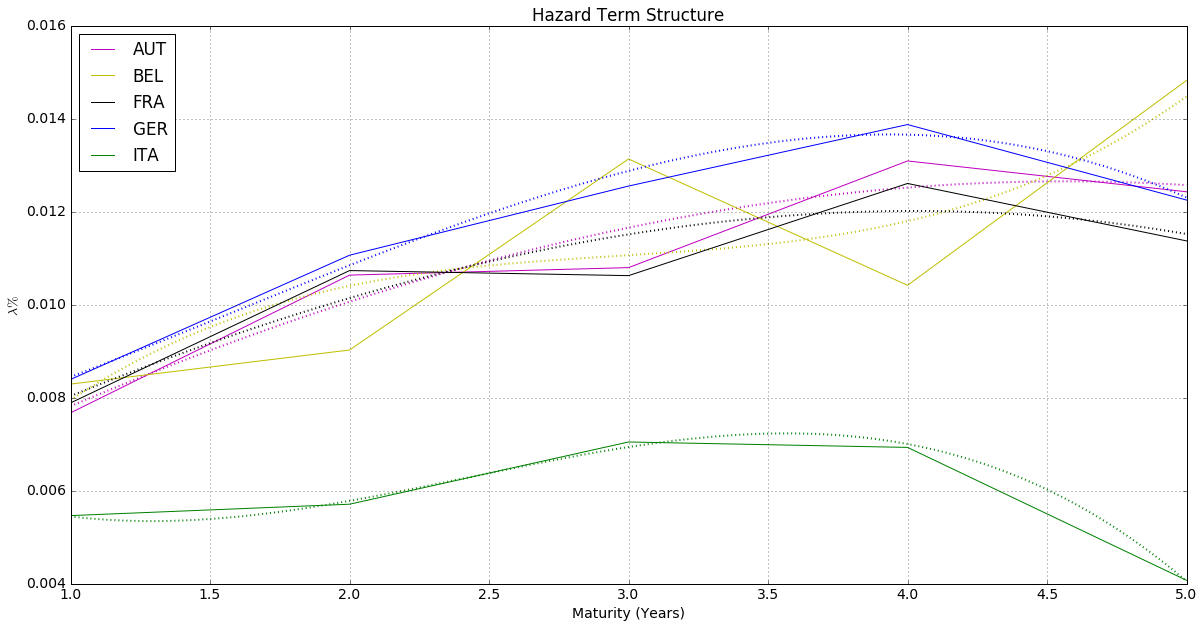

In [5]:
autData = [{'year': 1, 'spread': 115.70, 'Psurv': 0.982479122318651, 'hzdRate': 0.00767666961222201},
           {'year': 2, 'spread': 120.80, 'Psurv': 0.958704317759161, 'hzdRate': 0.01063864706076580},
           {'year': 3, 'spread': 141.30, 'Psurv': 0.935158751440165, 'hzdRate': 0.01079934088002760},
           {'year': 4, 'spread': 142.35, 'Psurv': 0.907384926248782, 'hzdRate': 0.01309378208757440},
           {'year': 5, 'spread': 154.70, 'Psurv': 0.881781194909988, 'hzdRate': 0.01243072764491560}]
belData = [{'year': 1, 'spread': 115.70, 'Psurv': 0.981081478816816, 'hzdRate': 0.00829492296551629},
           {'year': 2, 'spread': 120.80, 'Psurv': 0.960898216825752, 'hzdRate': 0.00902768958653353},
           {'year': 3, 'spread': 141.30, 'Psurv': 0.932269105082887, 'hzdRate': 0.01313609528367980},
           {'year': 4, 'spread': 142.35, 'Psurv': 0.910168391619283, 'hzdRate': 0.01041954293598230},
           {'year': 5, 'spread': 154.70, 'Psurv': 0.879621843358195, 'hzdRate': 0.01482574371445270}]
fraData = [{'year': 1, 'spread': 110.00, 'Psurv': 0.981996726677578, 'hzdRate': 0.00788995985891059},
           {'year': 2, 'spread': 129.80, 'Psurv': 0.958018344322737, 'hzdRate': 0.01073621502719710},
           {'year': 3, 'spread': 135.90, 'Psurv': 0.934859797608484, 'hzdRate': 0.01062734118316680},
           {'year': 4, 'spread': 145.65, 'Psurv': 0.908106923903281, 'hzdRate': 0.01260949694348420},
           {'year': 5, 'spread': 148.20, 'Psurv': 0.884632754882147, 'hzdRate': 0.01137397123783840}]
gerData = [{'year': 1, 'spread': 117.10, 'Psurv': 0.980856942015007, 'hzdRate': 0.00839432985148177},
           {'year': 2, 'spread': 135.70, 'Psurv': 0.956178825998711, 'hzdRate': 0.01106654787067210},
           {'year': 3, 'spread': 148.70, 'Psurv': 0.928935070875451, 'hzdRate': 0.01255376280085040},
           {'year': 4, 'spread': 159.65, 'Psurv': 0.899723183928248, 'hzdRate': 0.01387644802038900},
           {'year': 5, 'spread': 161.90, 'Psurv': 0.874694817786536, 'hzdRate': 0.01225235794298400}]
itaData = [{'year': 1, 'spread': 76, 'Psurv': 0.987491770901909, 'hzdRate': 0.00546651480710512},
           {'year': 2, 'spread': 77.7, 'Psurv': 0.974589948425733, 'hzdRate': 0.00571155728341799},
           {'year': 3, 'spread': 84.4, 'Psurv': 0.958897577274220, 'hzdRate': 0.00704970655753197},
           {'year': 4, 'spread': 87.35, 'Psurv': 0.943711257709229, 'hzdRate': 0.00693308549188108},
           {'year': 5, 'spread': 81.4, 'Psurv': 0.934898164118376, 'hzdRate': 0.00407482891279857}]
xRange = arange(0,5)

from pandas import DataFrame

# convert lists above into DataFrames
hazardDataA = DataFrame(autData)
hazardDataB = DataFrame(belData)
hazardDataF = DataFrame(fraData)
hazardDataG = DataFrame(gerData)
hazardDataI = DataFrame(itaData)

# plot term structure
def plotTermStructure(xdata=array, ydata=array, label=str):
    lincol = cycol()
    plt.plot(xdata, ydata,c=lincol, ms=5, label=label)
    spl = UnivariateSpline(xdata, ydata)
    xs = linspace(min(xdata), len(xdata), 1000)
    spl.set_smoothing_factor(0.5)
    plt.plot(xs, spl(xs),':k', c=lincol, lw=2)
    
plotTermStructure(hazardDataA['year'], hazardDataA['hzdRate'], 'AUT')
plotTermStructure(hazardDataA['year'], hazardDataB['hzdRate'], 'BEL')
plotTermStructure(hazardDataA['year'], hazardDataF['hzdRate'], 'FRA')
plotTermStructure(hazardDataA['year'], hazardDataG['hzdRate'], 'GER')
plotTermStructure(hazardDataA['year'], hazardDataI['hzdRate'], 'ITA')

plt.title('Hazard Term Structure')
plt.xlabel('Maturity (Years)')
plt.ylabel('$\lambda \%$')
plt.grid()
plt.legend(loc='upper left')



### Default Times via Copula Sampling

To calculate the spread of the basket of assets, we will need to use a technique involving sampling from the Gaussian and Student t's copula. The first step is to generate a vector of correlated uniform variables $(u_1, ... u_n)$ and then convert this vector of correlated uniform variables. 

#### Copula Approach

Copula sampling provides a dependent structure for the marginal distributions of our correlated assets. It is used to recover the joint distribution of default times for the asset pool. The default time $\tau_i$ can be tranformed using its own CDF the we can use the standard Normal CDF again to convert it form uniform to the normal space:

$x_i = \Phi^{-1}(u_i) = \Phi^{-1}(F_i(\tau_i))$

Sklar demonstrated that for any joint distribution there exists some copula function. 

#### Multivariate Gaussian Copula

$C(u_1,u_2,..., u_n) = \Phi_n(\Phi^{-1}(u_1),...,\Phi^{-1}(u_n);\Sigma$

where $\Phi_n$ is the CDF for the multivariate standard Normal Distribution. This along with the Student T distribution have no closed form solutions. The copula density function for n-dimensions can be expressed in matrix form:

$c(\Phi(x_1),\Phi(x_2),...,\Phi(x_n)) = \large \frac{\frac{1}{\sqrt{2\pi^n\div\sigma\div}} exp (-\frac{1}{2}X'\Sigma^{-1}X)}{\Pi_{i=1}^n \frac{1}{\sqrt{2\pi}} exp (-1\frac{1}{2}x_i^2) }$

$  $

ADD PLOTS

#### Student T Copula

$C($

ADD PLOTS






In [6]:
from scipy.stats import t
import app.rng as rng

# plots of uniform vectors (u1,...,u5)
def generateRandomSampleMatrix(sims=int, basketSize=1):
    """
    generate a matrix of two independent standard normal variables,
    $Z_1, Z_2$

    nb: it will source these via GPU is CUDA drivers are installed and configured correctly.
    :param sims:
    :return:
    """
    shape = (basketSize, sims)
    if gpuEnabled:
        return rng.getPseudoRandomNumbers_Standard_cuda(shape)

    return rng.getPseudoRandomNumbers_Standard(shape)


def generateRandomTSampleMatrix(sims=int, basketSize=1, dof=2.74335149908):
    """
    generate a matrix of n independent variables from t distribution,
    $Z_1, Z_2$

    nb: not available on GPU
    :param sims:
    :return:
    """

    return t.rvs(df=dof, size=(sims, basketSize))


This is the outline of the Copula sample method built using python.

```python
## Copula.py

from numpy import array, log, sqrt, square, random
from pandas import DataFrame
from scipy.stats import pearsonr, spearmanr, norm, t, chi2

def getPearsonRank(data=array):
    """

    method to provide Pearson Rank calculation given a data structure of
    two normally distributed variables

    :param data:
    :return: float;
    """

    return pearsonr(data[0], data[1])


def getSpearmanRank(data=array):
    """

    :param data:
    :return tuple: rank co-efficient, p value
    """
    return spearmanr(data[0], data[1])


def simulateCopula(simulations=10, type=str('g'), rho=float, lamda=tuple, tDof=4, basketSize=5, useGPU=False):
    result = []
    """

    $\tau = F^{-1}(u) = -\frac{log(1-u)}{\lambda}$

    """
    print 'simulating t distribution' if type == 't' else 'simulating gaussian dist'

    for z in xrange(0, simulations):
        # for the t distribution we use the same method but
        # sample from the chisquared distribution
        # if GPU is enabled, hand over to GPU to provide random number sample
        if useGPU and type == 'g':
            z1, z2, z3, z4, z5 = rng.getPseudoRandomNumbers_Standard_cuda(basketSize)
        else:
            z1, z2, z3, z4, z5 = chi2.rvs(tDof, size=5) if type == 't' else random.normal(size=5)
        # z1, z2, z3, z4, z5 = chi2.rvs(1, size=5) if type == 't' else random.normal(size=5)

        x1 = z1

        # using factorised copula procedure
        # $A_i = w_iZ + \sqrt{1-w{^2}{_i}\Epsilon_i $
        x2, x3, x4, x5 = [z1 * rho + sqrt(1 - square(rho)) * zn for zn in [z2, z3, z4, z5]]

        # converting to normal variables from t or normal distribution successfully
        # via cdf of relevant distribution
        if type == 't':
            u1, u2, u3, u4, u5 = [t.cdf(x, 1) for x in [x1, x2, x3, x4, x5]]
        else:
            u1, u2, u3, u4, u5 = [norm.cdf(x) for x in [x1, x2, x3, x4, x5]]
        u = [u1, u2, u3, u4, u5]
        # $\tau_i = -\frac{-log(1-u)}{\lambda_i} $
        tau1, tau2, tau3, tau4, tau5 = [-log(1 - u) / lamda[index] for index, u in enumerate(u)]
        result.append({'z1': z1,
                       'z2': z2,
                       'z3': z3,
                       'z4': z4,
                       'z5': z5,
                       'x1': x1,
                       'x2': x2,
                       'x3': x3,
                       'x4': x4,
                       'x5': x5,
                       'u1': u1,
                       'u2': u2,
                       'u3': u3,
                       'u4': u4,
                       'u5': u5,
                       'tau1': tau1,
                       'tau2': tau2,
                       'tau3': tau3,
                       'tau4': tau4,
                       'tau5': tau5,
                       })

    return DataFrame(result)
```

In [7]:
from scipy.stats import t

# basket.py

gpuEnabled = False
numberOfSimulations = 1000
z = generateRandomSampleMatrix(numberOfSimulations)
tSim = generateRandomTSampleMatrix(numberOfSimulations)

RHO = 0.1

import app.Copula as Copula
from pandas import ExcelWriter
# simulating Copula functions
# g = Copula.simulateCopula(numberOfSimulations, rho=RHO, type='g', intensity=(reference.intensity, reference2.intensity))
t = Copula.simulateCopula(numberOfSimulations, rho=RHO, type='t', lamda=hazardDataA['hzdRate'])
t1 = Copula.simulateCopula(numberOfSimulations, rho=RHO, type='t', lamda=hazardDataB['hzdRate'])
t2 = Copula.simulateCopula(numberOfSimulations, rho=RHO, type='t', lamda=hazardDataF['hzdRate'])
t3 = Copula.simulateCopula(numberOfSimulations, rho=RHO, type='t', lamda=hazardDataG['hzdRate'])
t4 = Copula.simulateCopula(numberOfSimulations, rho=RHO, type='t', lamda=hazardDataI['hzdRate'])

g = Copula.simulateCopula(numberOfSimulations, rho=RHO, type='g', lamda=hazardDataA['hzdRate'])
g1 = Copula.simulateCopula(numberOfSimulations, rho=RHO, type='g', lamda=hazardDataB['hzdRate'])
g2 = Copula.simulateCopula(numberOfSimulations, rho=RHO, type='g', lamda=hazardDataF['hzdRate'])
g3 = Copula.simulateCopula(numberOfSimulations, rho=RHO, type='g', lamda=hazardDataG['hzdRate'])
g4 = Copula.simulateCopula(numberOfSimulations, rho=RHO, type='g', lamda=hazardDataI['hzdRate'])

tc = DataFrame()
tc['u1'] = t['u1']
tc['u2'] = t['u2']
tc['u3'] = t['u3']
tc['u4'] = t['u4']
tc['u5'] = t['u5']
tcp = tc.corr() # pearson as default
tck = tc.corr('kendall') # kendall 

print tcp

print 'Correlation matrix (kendall) of u1...u5 of t dist sample'
print tck

from sklearn import preprocessing

x = tck.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
tckn = DataFrame(x_scaled)

print 'Normalised matrix'
print tckn


# output the files to csv for import into Excel
writer = ExcelWriter('copulaSimulation-web.xlsx')
t.to_excel(writer, 'T-Austria')
t1.to_excel(writer, 'T-Belgium')
t2.to_excel(writer, 'T-France')
t3.to_excel(writer, 'T-Germany')
t4.to_excel(writer, 'T-Italy')

g.to_excel(writer, 'G-Austria')
g1.to_excel(writer, 'G-Belgium')
g2.to_excel(writer, 'G-France')
g3.to_excel(writer, 'G-Germany')
g4.to_excel(writer, 'G-Italy')

writer.save()

print 'copula simulation data written to \'./copulationSimulation-web.xlsx\''



simulating t distribution
simulating t distribution
simulating t distribution
simulating t distribution
simulating t distribution
simulating gaussian dist
simulating gaussian dist
simulating gaussian dist
simulating gaussian dist
simulating gaussian dist
          u1        u2        u3        u4        u5
u1  1.000000  0.138698  0.055318  0.063099  0.104402
u2  0.138698  1.000000  0.055002 -0.000546  0.017490
u3  0.055318  0.055002  1.000000  0.052822  0.073934
u4  0.063099 -0.000546  0.052822  1.000000  0.054046
u5  0.104402  0.017490  0.073934  0.054046  1.000000
Correlation matrix of u1...u5 of t dist sample           u1        u2        u3        u4        u5
u1  1.000000  0.074430  0.059584  0.059696  0.086951
u2  0.074430  1.000000  0.029109 -0.016320  0.012056
u3  0.059584  0.029109  1.000000  0.026010  0.036817
u4  0.059696 -0.016320  0.026010  1.000000  0.022747
u5  0.086951  0.012056  0.036817  0.022747  1.000000
Normalised matrix           0         1         2         3   

View results here http://cqf.morphean.co.uk/notebooks/cva/notebook/copulationSimulation-web.xlsx

In [1]:


def plotDistributions(xdata=array, ydata=array, label=str):
    lincol = cycol()
    plt.plot(xdata, ydata, 'ro',c=lincol, ms=5, label=label)

plotDistributions(t['z1'],t['z2'], 'AUT')
plotDistributions(t['z1'],t1['z2'], 'BEL')
plotDistributions(t['z1'],t2['z2'], 'FRA')
plotDistributions(t['z1'],t3['z2'], 'GER')
plotDistributions(t['z1'],t4['z2'], 'ITA')

plt.title('Sampling from Student\'s t')
plt.xlabel('Maturity (Years)')
plt.ylabel('$\lambda \%$')
plt.grid()
plt.legend(loc='upper left')

NameError: name 'array' is not defined

In [ ]:
plotDistributions(g['z1'],g['z2'], 'AUT')
plotDistributions(g1['z1'],g1['z2'], 'BEL')
plotDistributions(g2['z1'],g2['z2'], 'FRA')
plotDistributions(g3['z1'],g3['z2'], 'GER')
plotDistributions(g4['z1'],g4['z2'], 'ITA')

plt.title('Sampling the Gaussian distribution')
plt.grid()
plt.legend(loc='upper left')

In [ ]:
tu = DataFrame()
tu['u1'] = t['u1']
tu['u3'] = t['u3']
tu['u4'] = t['u4']
tu['u5'] = t['u5']
tu.corr()

In [ ]:
plotDistributions(t['u1'],t['u2'], 'AUT')
plotDistributions(t1['u1'],t1['u2'], 'BEL')
plotDistributions(t2['u1'],t2['u2'], 'FRA')
plotDistributions(t3['u1'],t3['u2'], 'GER')
plotDistributions(t4['u1'],t4['u2'], 'ITA')

plt.title('Student\'s t distribution of u')
plt.xlabel('Maturity (Years)')
plt.ylabel('$\lambda \%$')
plt.grid()
plt.legend(loc='upper left')

### Year of Default

To find the year of default we need to iterate through the term structure of hazard rates by summing $\lambda_i$ until the cumulative probabilty of default breaches the threshold of the hazard rate. At this point we know that the credit event has taken place.

<center>$\tau=inf\large\{ t > 0 : log(1-u) \geqslant - \Sigma^t \lambda_m \large \}$</center>

Once the year of default is known we can estimate the year fraction $\delta t$

### Correlation Matrix

#### Correlation Matrices of historic data



In order to determine the implied correlation from the copula sampling we can obtain the correlation matrix, using historical data for sovereign cds from http://www.dbresearch.com/servlet/reweb2.ReWEB?rwobj=cdscalc2.Start.class&rwnode=DBR_INTERNET_EN-PROD%5C%24EM%5C&rwsite=DBR_INTERNET_EN-PROD&cdsRecRate=40


|         | Austria     | Belgium      | France     | Germany     |   Italy     |
|---------|-------------|-------------|-------------|-------------|-------------|
| Austria | 1           | 0.145283949 | 0.127878282 | 0.076963708 | 0.18077213  |
| Belgium | 0.145283949 | 1           | 0.186085976 | 0.093729402 | 0.308384127 |
| France  | 0.127878282 | 0.186085976 | 1           | 0.134759431 | 0.340827304 |
| Germany | 0.076963708 | 0.093729402 | 0.134759431 | 1           | 0.144273981 |
| Italy   | 0.18077213  | 0.308384127 | 0.340827304 | 0.144273981 | 1           |

<center>** Historic Correlation of Log returns**</center>

|           | Austria   | Belgium   | France    | Germany   |   Italy   |
|-----------|-------------|-------------|-------------|-------------|-------------|
| Austria | 1           | 0.455575258 | 0.072697856 | 0.341614537 | 0.430669391 |
| Belgium | 0.455575258 | 1           | 0.663961517 | 0.781885008 | 0.735314391 |
| France | 0.072697856 | 0.663961517 | 1           | 0.611406293 | 0.531623133 |
| Germany | 0.341614537 | 0.781885008 | 0.611406293 | 1           | 0.596003097 |
| Italy   | 0.430669391 | 0.735314391 | 0.531623133 | 0.596003097 | 1           |

<center>** Historic Correlation of Probabilty of Default**</center>

## Conclusion


It has been both a challenging and rewarding exercise in which to build a practical application. Learning not only about implementation of the models discussed throughout the course, but learning new computational languages (Python, pyCUDA, latex) and discovering new libraries in the field (NAG).

Initially I started looking at QuantLib, but its learning curve is very very steep and does not feel like a newbie toolkit at all, combined with the memory management and other aspects of C++ my preferred choice and still is Python. It has provided an incredible base on which to learn and lots of routines and statistical methods are built-in or provided by NumPy and SciPy. Working with LateX has also been very appealing, and considering my day job is a Front End Engineer I am considering rewriting this in JavaScript, with a potential Desktop version built using Electron http://electron.atom.io/docs/faq/.

Improvements

- More use of MKL, CUDA libraries, especially the cudajit to enhance performance especially when considering scaling up of calculations.

- Integration of the NAG library, a licence was courteously provided by the Numerical Algorithms Group. And compare how these routines compare with the Intel optimised and CUDA routines.

- Try and introduce parallel processing for offloading larger monte carlo set on to different network nodes.

- Explore use of Cython.

- Somehow get the CUDA libraries running on a server with GPU capability.

- Provide a containerised portable environment based on Docker and Ansible for running simulations

